#LSTM AND BI-LSTM for Temperature Prediction

In [101]:
import tensorflow as tf
import os
import pandas as pd
import numpy as np
import matplotlib as mpl
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from matplotlib import pyplot as plt
from torch.utils.data import DataLoader, random_split, Dataset
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import seaborn as sns
# from google.colab import files
# mpl.rcParams['figure.figsize'] = (12,8)
mpl.rcParams['axes.grid'] = True
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


**Data Importation and Information**

In [102]:
df = pd.read_csv('/Users/ange-clementakazan/Documents/Weather_Prediction_project/Deep-Learning-for-Weather-Prediction/data/Abj_Weather_Prediction.csv')
# print(df.info())
df.describe()
# df.head(4) 

,YEAR,DOY,T2M,WS2M,PRECTOTCORR,RH2M,QV2M,CLRSKY_SFC_SW_DWN,T2MDEW,ALLSKY_SFC_LW_DWN
count,3409.000000,3409.000000,3409.000000,3409.000000,3409.000000,3409.000000,3409.000000,3409.000000,3409.000000,3409.000000
mean,2019.178351,178.759167,26.379475,2.260032,4.527832,84.605937,18.050745,22.597392,23.387366,412.083972
std,2.700394,106.187731,1.210199,0.601769,5.944318,5.684864,1.386845,2.192356,1.409179,8.308417
min,2015.000000,1.000000,22.940000,0.410000,0.000000,44.620000,8.850000,13.720000,11.690000,349.850000
25%,2017.000000,86.000000,25.440000,1.800000,0.900000,82.620000,17.400000,21.320000,22.860000,408.490000
50%,2019.000000,176.000000,26.460000,2.220000,2.680000,85.940000,18.310000,23.230000,23.670000,413.230000
75%,2021.000000,271.000000,27.190000,2.700000,5.750000,88.310000,18.920000,24.240000,24.230000,417.230000
max,2024.000000,366.000000,30.010000,4.400000,70.120000,94.000000,20.870000,26.140000,25.860000,433.270000


In [103]:
#Rename Columns
df.columns=['YEAR','Days','DOY','T2M', 'WS2M', 'PREC', 'RH2M', 'QV2M',
       'CSSWDW', 'T2MDEW', 'ALLSKYDW']
       

**Variable ploting**

In [104]:
# df['Days'] = pd.to_datetime(df['Days'], dayfirst=True)
# df.index = pd.to_datetime(df['Days'],infer_datetime_format=True )
# plt.figure(figsize=(9,9))
# df.set_index('Days')[['T2M', 'WS2M', 'PREC', 'RH2M', 'QV2M',
#        'CSSWDW', 'T2MDEW', 'ALLSKYDW']].plot(subplots=True)


In [105]:
#Handle missing values
df = df.fillna(method='ffill')  # Forward fill for simplicity, or use df.dropna() to remove rows with NaNs
print(df.isnull().sum())  # Verify no missing values remain


YEAR        0
Days        0
DOY         0
T2M         0
WS2M        0
PREC        0
RH2M        0
QV2M        0
CSSWDW      0
T2MDEW      0
ALLSKYDW    0
dtype: int64


In [108]:
#################### Datapreprocessing For Temperature   #####################

# Scalling
df_input= df[['T2M', 'WS2M', 'PREC', 'RH2M', 'QV2M',
       'CSSWDW', 'T2MDEW', 'ALLSKYDW']].sort_index()
scaler = MinMaxScaler()
data_scaled = scaler.fit_transform(df_input)
# Define features and target
features = data_scaled
target = data_scaled[:, 0]  # Assuming 'T2M' is the target

# Splitting the dataset into training, validation, and test sets
train_size = int(len(target)*0.8)
val_size =int(train_size*0.10)
#Train_val_test sets
X_train, y_train = features[:train_size-val_size, :], target[:train_size-val_size]
X_val, y_val = features[train_size-val_size:train_size, :], target[train_size-val_size:train_size]
X_test,y_test= features[train_size:, :], target[train_size:]

# Define the TimeSeriesDataset class
class TimeSeriesDataset(Dataset):
    def __init__(self, features, target, window_length):
        self.features = features
        self.target = target
        self.window_length = window_length
    def __len__(self):
        return len(self.features) - self.window_length
    def __getitem__(self, idx):
        X = self.features[idx:idx + self.window_length]
        y = self.target[idx + self.window_length]
        return torch.tensor(X, dtype=torch.float32), torch.tensor(y, dtype=torch.float32)

# Create datasets
window_length = 14
train_dataset = TimeSeriesDataset(X_train, y_train, window_length)
val_dataset = TimeSeriesDataset(X_val, y_val, window_length)
test_dataset = TimeSeriesDataset(X_test, y_test, window_length)

# Create DataLoaders
batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


# Models 

In [109]:
########################################################################################################################
#####################################  Recurrent Network Model for    Temperature prediction       #################################
########################################################################################################################

#LSTM
class LSTMModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, dropout_prob):
        super(LSTMModel, self).__init__()       
        # Define LSTM layer
        self.lstm = nn.LSTM(input_dim, hidden_dim, batch_first=True)       
        # Define Dropout layer
        self.dropout = nn.Dropout(dropout_prob)   
        # Define Dense layer
        self.fc = nn.Linear(hidden_dim, output_dim)       
    def forward(self, x):
        # Forward pass through LSTM
        lstm_out, _ = self.lstm(x)      
        # Apply dropout to LSTM output
        lstm_out = self.dropout(lstm_out[:, -1, :])  # Use the output of the last time step       
        # Forward pass through Dense layer
        out = self.fc(lstm_out)
        return out
    
#GRU
class GRUModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, dropout_prob):
        super(GRUModel, self).__init__()       
        # Define LSTM layer
        self.gru = nn.GRU(input_dim, hidden_dim, batch_first=True)       
        # Define Dropout layer
        self.dropout = nn.Dropout(dropout_prob)   
        # Define Dense layer
        self.fc = nn.Linear(hidden_dim, output_dim)       
    def forward(self, x):
        # Forward pass through LSTM
        gru_out, _ = self.gru(x)      
        # Apply dropout to LSTM output
        gru_out = self.dropout(gru_out[:, -1, :])  # Use the output of the last time step       
        # Forward pass through Dense layer
        out = self.fc(gru_out)
        return out
#BiLSTM
class BiLSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, num_layers=1, dropout=0.2):
        super(BiLSTM, self).__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers=num_layers, 
                            bidirectional=True, batch_first=True, dropout=dropout)
        self.fc = nn.Linear(hidden_dim * 2, output_dim)  # *2 for bidirectional

    def forward(self, x):
        h_lstm, _ = self.lstm(x)
        out = self.fc(h_lstm[:, -1, :])  # Use the output of the last time step
        return out
#BiGRU
class BiGRU(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, num_layers=1, dropout=0.2):
        super(BiGRU, self).__init__()
        self.gru = nn.GRU(input_dim, hidden_dim, num_layers=num_layers, 
                          bidirectional=True, batch_first=True, dropout=dropout)
        self.fc = nn.Linear(hidden_dim * 2, output_dim)  # *2 for bidirectional

    def forward(self, x):
        h_gru, _ = self.gru(x)
        out = self.fc(h_gru[:, -1, :])  # Use the output of the last time step
        return out


# Early Stopping Function

In [167]:
#Early stopping Class
class EarlyStopping:
    def __init__(self, patience=50, mode='min', verbose=False):
        self.patience = patience
        self.mode = mode
        self.verbose = verbose
        self.best_score = np.inf if mode == 'min' else -np.inf
        self.early_stop = False
        self.counter = 0
    def __call__(self, score):
        if self.mode == 'min':
            if score < self.best_score:
                self.best_score = score
                self.counter = 0
                if self.verbose:
                    print(f'Validation loss decreased ({self.best_score:.6f} --> {score:.6f}).  Saving model...')
            else:
                self.counter += 1
                if self.counter >= self.patience:
                    self.early_stop = True
                    if self.verbose:
                        print(f'Early stopping triggered after {self.patience} epochs with no improvement.')
        elif self.mode == 'max':
            if score > self.best_score:
                self.best_score = score
                self.counter = 0
                if self.verbose:
                    print(f'Validation metric increased ({self.best_score:.6f} --> {score:.6f}).  Saving model...')
            else:
                self.counter += 1
                if self.counter >= self.patience:
                    self.early_stop = True
                    if self.verbose:
                        print(f'Early stopping triggered after {self.patience} epochs with no improvement.')




# Model Initialization

In [168]:
# Initialize models
input_dim = X_train.shape[1]
hidden_dim = 64
output_dim = 1
num_layers = 2
#LSTM
model_lstm = LSTMModel(input_dim=features.shape[1] , hidden_dim=94, output_dim=1, dropout_prob=0.2).to(device)
optimizer_lstm = optim.Adam(model_lstm.parameters(), lr=0.001)
#GRU
model_gru= GRUModel(input_dim=features.shape[1] , hidden_dim=94, output_dim=1, dropout_prob=0.2).to(device)
optimizer_gru = optim.Adam(model_gru.parameters(), lr=0.001)
# For BiLSTM
model_bilstm = BiLSTM(input_dim, hidden_dim, output_dim, num_layers).to(device)
optimizer_bilstm = optim.Adam(model_bilstm.parameters(), lr=0.001)

# For BiGRU
model_bigrus = BiGRU(input_dim, hidden_dim, output_dim, num_layers).to(device)
optimizer_bigrus = optim.Adam(model_bigrus.parameters(), lr=0.001)


# Training Functions

In [177]:

# Initialize early stopping
patience=150
early_stopping = EarlyStopping(patience=patience, mode='min', verbose=True)
# Define the loss function and optimizer
criterion = nn.MSELoss()
#Define metrics
def rmse(predictions, targets):
    return torch.sqrt(torch.mean((predictions - targets) ** 2)).item()
def mae(predictions, targets):
    return torch.mean(torch.abs(predictions - targets)).item()
# Training function
def training_function(model,train_loader,val_loader,optimizer,num_epochs=160):
    train_losses = []
    val_losses = []
    final_losses=[]
    for epoch in range(num_epochs):
        model.train()  # Set model to training mode
        running_loss = 0.0
        running_rmse = 0.0
        running_mae = 0.0  
        # Training phase
        for X_batch, y_batch in train_loader:
            X_batch,y_batch=X_batch.to(device),y_batch.to(device)
            optimizer.zero_grad()
            outputs = model(X_batch)
            loss = criterion(outputs.squeeze(), y_batch)
            loss.backward()
            optimizer.step()
            running_loss += loss.item() * X_batch.size(0)
            running_rmse += rmse(outputs.squeeze(), y_batch) * X_batch.size(0)
            running_mae += mae(outputs.squeeze(), y_batch) * X_batch.size(0)
        # Cumulative training loss 
        epoch_train_loss = running_loss / len(train_loader.dataset)
        epoch_train_rmse = running_rmse / len(train_loader.dataset)
        epoch_train_mae = running_mae / len(train_loader.dataset)
        train_losses.append(epoch_train_loss)
        # Validation phase 
        model.eval() # Set model to validation model
        val_loss = 0.0
        val_rmse = 0.0
        val_mae = 0.0
        with torch.no_grad():
            for X_batch, y_batch in val_loader:
                X_batch,y_batch=X_batch.to(device),y_batch.to(device)
                outputs = model(X_batch)
                loss = criterion(outputs.squeeze(), y_batch)
                val_loss += loss.item() * X_batch.size(0)
                val_rmse += rmse(outputs.squeeze(), y_batch) * X_batch.size(0)
                val_mae += mae(outputs.squeeze(), y_batch) * X_batch.size(0)
        # Cumulative validation loss 
        epoch_val_loss = val_loss / len(val_loader.dataset)
        epoch_val_rmse = val_rmse / len(val_loader.dataset)
        epoch_val_mae = val_mae / len(val_loader.dataset)
        val_losses.append(epoch_val_loss)
        if (epoch+1) %50==0:
            # Print losses and metrics
            print(f'Epoch {epoch+1}/{num_epochs}')
            print(f'Training Loss: {epoch_train_loss:.4f}, RMSE: {epoch_train_rmse:.4f}, MAE: {epoch_train_mae:.4f}')
            print(f'Validation Loss: {epoch_val_loss:.4f}, RMSE: {epoch_val_rmse:.4f}, MAE: {epoch_val_mae:.4f}')
            print('------------------------------------')  
        # Check early stopping
        early_stopping(epoch_val_loss)
        if early_stopping.early_stop:
            print('Early stopping')
            break
    final_losses.append([[epoch_train_loss,epoch_train_rmse,epoch_train_mae],[epoch_val_loss,epoch_val_rmse,epoch_val_mae]])
    return train_losses, val_losses,final_losses

In [170]:
#LSTM
history_lstm=training_function(model_lstm,train_loader,val_loader,optimizer_lstm,num_epochs=400)

Validation loss decreased (0.009124 --> 0.009124).  Saving model...
Validation loss decreased (0.005275 --> 0.005275).  Saving model...
Validation loss decreased (0.004489 --> 0.004489).  Saving model...
Validation loss decreased (0.004089 --> 0.004089).  Saving model...
Validation loss decreased (0.003747 --> 0.003747).  Saving model...
Validation loss decreased (0.003494 --> 0.003494).  Saving model...
Validation loss decreased (0.003361 --> 0.003361).  Saving model...
Validation loss decreased (0.003355 --> 0.003355).  Saving model...
Validation loss decreased (0.003275 --> 0.003275).  Saving model...
Validation loss decreased (0.003241 --> 0.003241).  Saving model...
Validation loss decreased (0.003239 --> 0.003239).  Saving model...
Validation loss decreased (0.003167 --> 0.003167).  Saving model...
Validation loss decreased (0.003144 --> 0.003144).  Saving model...
Validation loss decreased (0.003115 --> 0.003115).  Saving model...
Validation loss decreased (0.003075 --> 0.003075

In [173]:
#GRU
history_gru=training_function(model_gru,train_loader,val_loader,optimizer_gru,num_epochs=400)


Validation loss decreased (0.004232 --> 0.004232).  Saving model...
Validation loss decreased (0.003729 --> 0.003729).  Saving model...
Validation loss decreased (0.003549 --> 0.003549).  Saving model...
Validation loss decreased (0.003522 --> 0.003522).  Saving model...
Validation loss decreased (0.003312 --> 0.003312).  Saving model...
Validation loss decreased (0.003302 --> 0.003302).  Saving model...
Validation loss decreased (0.003249 --> 0.003249).  Saving model...
Validation loss decreased (0.003184 --> 0.003184).  Saving model...
Validation loss decreased (0.003151 --> 0.003151).  Saving model...
Validation loss decreased (0.003115 --> 0.003115).  Saving model...
Validation loss decreased (0.003105 --> 0.003105).  Saving model...
Validation loss decreased (0.003081 --> 0.003081).  Saving model...
Validation loss decreased (0.003068 --> 0.003068).  Saving model...
Validation loss decreased (0.003060 --> 0.003060).  Saving model...
Validation loss decreased (0.003026 --> 0.003026

In [175]:
#BiLSTM
history_bilstm=training_function(model_bilstm,train_loader,val_loader,optimizer_bilstm,num_epochs=400)


Validation loss decreased (0.007901 --> 0.007901).  Saving model...
Validation loss decreased (0.004245 --> 0.004245).  Saving model...
Validation loss decreased (0.003659 --> 0.003659).  Saving model...
Validation loss decreased (0.003423 --> 0.003423).  Saving model...
Validation loss decreased (0.003331 --> 0.003331).  Saving model...
Validation loss decreased (0.003292 --> 0.003292).  Saving model...
Validation loss decreased (0.003205 --> 0.003205).  Saving model...
Validation loss decreased (0.003196 --> 0.003196).  Saving model...
Validation loss decreased (0.003176 --> 0.003176).  Saving model...
Validation loss decreased (0.003121 --> 0.003121).  Saving model...
Validation loss decreased (0.003107 --> 0.003107).  Saving model...
Validation loss decreased (0.003080 --> 0.003080).  Saving model...
Validation loss decreased (0.003069 --> 0.003069).  Saving model...
Validation loss decreased (0.003065 --> 0.003065).  Saving model...
Epoch 50/400
Training Loss: 0.0032, RMSE: 0.0563

In [178]:
#BiGRU
history_bigru=training_function(model_bigrus, train_loader, val_loader,optimizer_bigrus, num_epochs=400)

Validation loss decreased (0.011112 --> 0.011112).  Saving model...
Validation loss decreased (0.004883 --> 0.004883).  Saving model...
Validation loss decreased (0.003936 --> 0.003936).  Saving model...
Validation loss decreased (0.003478 --> 0.003478).  Saving model...
Validation loss decreased (0.003322 --> 0.003322).  Saving model...
Validation loss decreased (0.003256 --> 0.003256).  Saving model...
Validation loss decreased (0.003163 --> 0.003163).  Saving model...
Validation loss decreased (0.003115 --> 0.003115).  Saving model...
Validation loss decreased (0.003112 --> 0.003112).  Saving model...
Validation loss decreased (0.003075 --> 0.003075).  Saving model...
Validation loss decreased (0.003058 --> 0.003058).  Saving model...
Validation loss decreased (0.003010 --> 0.003010).  Saving model...
Epoch 50/400
Training Loss: 0.0032, RMSE: 0.0560, MAE: 0.0426
Validation Loss: 0.0031, RMSE: 0.0545, MAE: 0.0424
------------------------------------
Validation loss decreased (0.00299

### Learning plot of each models

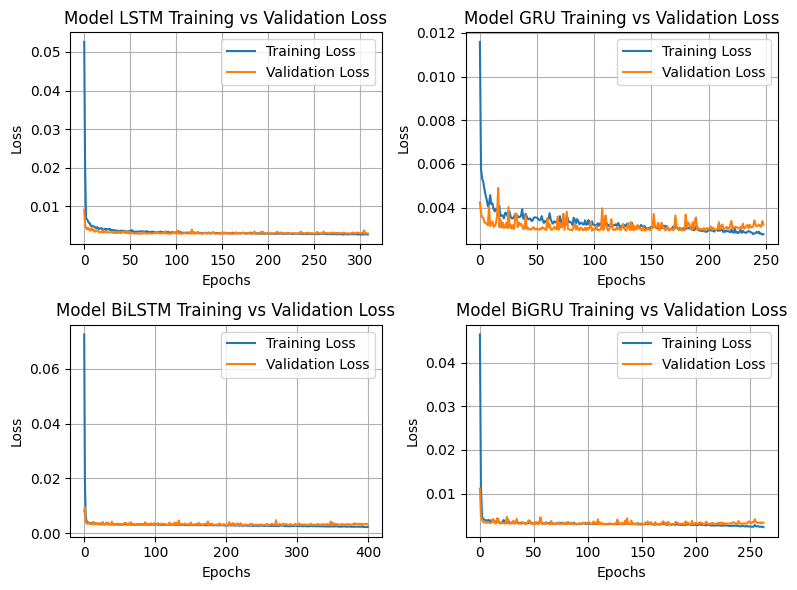

In [183]:
# Assume these are your histories
all_history = [history_lstm, history_gru, history_bilstm, history_bigru]
model_name=["LSTM","GRU","BiLSTM","BiGRU"]
# Create a figure and a set of subplots
fig, axs = plt.subplots(2, 2, figsize=(8, 6))  # One subplot per model
axs=axs.flatten()
# Loop through each history and corresponding axis
for i, history in enumerate(all_history):
    train_losses, val_losses, final_loss = history
    axs[i].plot(train_losses, label='Training Loss')
    axs[i].plot(val_losses, label='Validation Loss')
    axs[i].set_title(f'Model {model_name[i]} Training vs Validation Loss')
    axs[i].set_xlabel('Epochs')
    axs[i].set_ylabel('Loss')
    axs[i].legend()

# Adjust layout to prevent overlap
plt.tight_layout()
plt.show()





# Predictions

In [190]:
import torch
import torch.nn.functional as F
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

def mean_absolute_percentage_error(y_true, y_pred): 
    return torch.mean(torch.abs((y_true - y_pred) / y_true)) * 100

def evaluate_model(model, test_loader):
    model.eval()
    total_loss = 0.0
    y_true_list = []
    y_pred_list = []

    with torch.no_grad():
        for X_batch, y_batch in test_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            outputs = model(X_batch).squeeze()
            loss = criterion(outputs, y_batch)
            total_loss += loss.item() * X_batch.size(0)

            y_true_list.append(y_batch.cpu().numpy())
            y_pred_list.append(outputs.cpu().numpy())

    avg_loss = total_loss / len(test_loader.dataset)
    
    y_true = np.concatenate(y_true_list)
    y_pred = np.concatenate(y_pred_list)
    
    rmse = mean_squared_error(y_true, y_pred, squared=False)
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    mape = mean_absolute_percentage_error(torch.tensor(y_true), torch.tensor(y_pred))
    # print(f'Test Loss (MSE): {avg_loss:.4f}')
    # print(f'RMSE: {rmse:.4f}')
    # print(f'MAE: {mae:.4f}')
    # print(f'R²: {r2:.4f}')
    # print(f'MAPE: {mape:.4f}%')
    return [mape.numpy(),r2,mae,rmse,avg_loss]

# Eval LSTM
metrics_lstm=evaluate_model(model_lstm, test_loader)
#Eval GRU
metrics_gru=evaluate_model(model_gru, test_loader)
#Eval BiLSTM
metrics_bilstm=evaluate_model(model_bilstm, test_loader)
# Eval BiGRU
metrics_bigrus=evaluate_model(model_bigrus, test_loader)

In [196]:
result=pd.DataFrame( [metrics_lstm,metrics_gru,metrics_bilstm,metrics_bigrus],columns=['MAPE (%)','R²','MAE','RMSE','MSE'],index=['LSTM','GRU','BiLSTM','BiGRU'])
result


,MAPE (%),R²,MAE,RMSE,MSE
LSTM,10.914766,0.891079,0.045969,0.062432,0.003898
GRU,10.967823,0.892397,0.045021,0.062053,0.003851
BiLSTM,11.247849,0.883105,0.047522,0.064677,0.004183
BiGRU,11.680359,0.880116,0.047961,0.065499,0.004290


In [195]:
# # Evaluation pof MSE with the test_generator
# model.evaluate(test_generator,verbose=0)

# # Predictions
# predictions=model.predict(test_generator)

# # Consider the values of X_test by ignoring the first 14th
# New_X_test=X_test[:,1:][window_length:]

# # Datapredicted
# df_pred=pd.concat([pd.DataFrame(predictions),pd.DataFrame(New_X_test)],axis=1)
# # return the inverse transform of the MinMaxscaler created above to give the real value that we had initially
# rev_trans=scaler.inverse_transform(df_pred.values)

# # Extraction of the LSTM  prediction and the real value of T2M
# df_final=df_input[-predictions.shape[0]:]
# df1=df_final['T2M']
# rev2=rev_trans[:,0]

# from sklearn.metrics import mean_squared_error,mean_absolute_error,r2_score,mean_absolute_percentage_error

# # Performance metrics

# mse = mean_squared_error(df1, rev2)
# r2 = r2_score(df1, rev2)
# mae = mean_absolute_error(df1, rev2)
# # mae_scaled = mean_absolute_error(X_test[-rev2.shape[0]:,0], predictions[:,0])
# mape = mean_absolute_percentage_error(df1, rev2)
# print("mse=",mse,3)
# print("r2=",r2,3)
# print("mae=",mae)
# # print("mae_scaled=" + str(round(mae_scaled,2)))
# print("mape=",mape)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

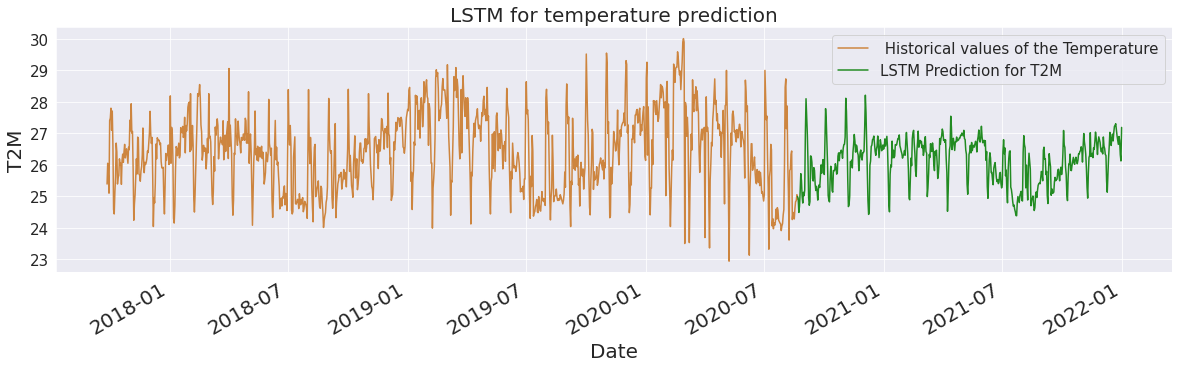

In [ ]:
# from google.colab import files

# ########## Visualization of LSTM Prediction result ##########

# dates = pd.date_range('08/21/2020', periods=498)
# dates1 = pd.date_range('01/01/2015', periods=2060)
# Forecast=pd.DataFrame({  'LSTM Prediction for T2M ':rev2})
# Forecast['date']=dates
# For=Forecast.set_index('date')
# T=df_input['T2M']
# D=T[0:2060].to_frame(' Historical values of the Temperature')
# D['Date']=dates1
# DD=D.set_index('Date')

# mpl.rcParams['xtick.labelsize'] = 20
# mpl.rcParams['ytick.labelsize'] = 15
# plt.rcParams['axes.labelsize'] = 20
# plt.rcParams['axes.titlesize'] = 20


# sns.set_style("darkgrid")
# train_forecast = pd.concat([DD,For])
# train_forecast[1000:2600].plot.line(figsize=(20, 5), color=['peru','forestgreen'])

# plt.ylabel("T2M",fontsize=20)
# plt.xlabel("Date",fontsize=20)

# plt.title("LSTM for temperature prediction")
# plt.legend(fontsize=15)
# plt.savefig('LSTM_TMP_PRED.png')
# files.download("LSTM_TMP_PRED.png")
# plt.show()



<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

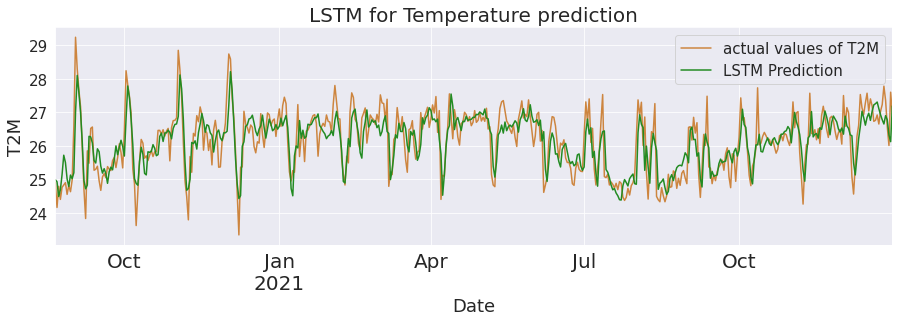

In [ ]:
# import matplotlib.dates as mdates
# Forecast=pd.DataFrame({'actual values of T2M':df1,'LSTM Prediction ':rev2})
# Forecast['date']=dates
# For=Forecast.set_index('date')
# # For.plot.line(figsize=(17, 4))
# train_forecast = pd.concat([DD,For])
# mpl.rcParams['xtick.labelsize'] = 20
# mpl.rcParams['ytick.labelsize'] = 15
# plt.rcParams['axes.labelsize'] = 20
# plt.rcParams['axes.titlesize'] = 20

# # train_forecast[2000:2600].plot.line(figsize=(15, 7))
# sns.set_style("darkgrid")

# For.plot.line(figsize=(15, 4),color=['peru','forestgreen'])
# plt.ylabel("T2M",fontsize=18)
# plt.xlabel("Date",fontsize=18)
# # dates.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
# # dates.xaxis.set_major_locator(mdates.DayLocator(interval=100))
# # dates.tick_params(axis='x', labelrotation=45)
# # train_forecast.plot.line(figsize=(35, 7))
# plt.title("LSTM for Temperature prediction")
# plt.legend(fontsize=15)
# plt.savefig('LSTM_TMP_PRED_VS.png')
# files.download("LSTM_TMP_PREDx.png")
# plt.show()



In [ ]:
# plt.scatter(rev2p, df1p,s=10,linewidths=True)
# plt.ylabel(" True Precipitation values")
# plt.xlabel("Predicted Precipitation values")
# plt.title("Scatter plot")
# Concatenated predicted and real values